In [1]:
import os
from pprint import pprint
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
import ceci

In [2]:
#user specific paths
my_txpipe_dir = "/pbs/home/m/mricci/throng_mricci/desc/TXPipe"
output_dir = '/pbs/home/m/mricci/throng_mricci/desc/TXPipe/data/example/inputs'

os.chdir(my_txpipe_dir)

import txpipe

# Let's start working with the 1deg2 data file

### Launching a pipeline at CC-IN2P3

Let's have a look at the submission script for this pipeline: `examples/cosmodc2/20deg2-in2p3.sub`:

In [3]:
! cat examples/cosmodc2/1deg2-in2p3.sub

#!/usr/bin/bash
#SBATCH --time=01:00:00
#SBATCH --partition=hpc
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=128000

source /pbs/throng/lsst/users/jzuntz/txpipe-environments/setup-txpipe
ceci examples/cosmodc2/pipeline-1deg2-CL.yml


This will launch a job of up to one hour (it should finish in 30 min) on a single CC-IN2P3 node to run a pipeline.

In a terminal, **navigate to your TXPipe directory and run**:

```
sbatch examples/cosmodc2/1deg2-in2p3.sub
```
to set it running.

In [4]:
# Read the appropriate pipeline configuration, and ask for a flow-chart.
pipeline_file = "examples/cosmodc2/pipeline-1deg2-CL.yml"
flowchart_file = "CL_pipeline.png"


pipeline_config = ceci.Pipeline.build_config(
    pipeline_file,
    flow_chart=flowchart_file,
    dry_run=True
)

# Run the flow-chart pipeline
ceci.run_pipeline(pipeline_config)

0

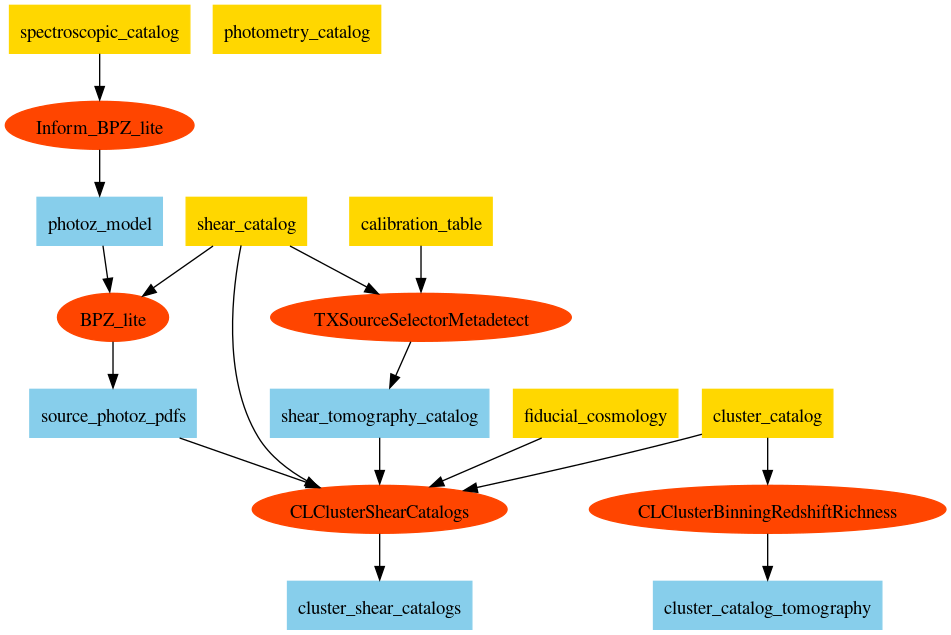

In [5]:
Image(flowchart_file)

In [6]:
# we can also use the notsbook interface for small data
##TOFIX: this saves the output in '.', do not account for the path given....

In [7]:
print("Options for this pipeline and their defaults (this may be override by config file):")
print(txpipe.extensions.CLClusterBinningRedshiftRichness.config_options)

pip_stage = txpipe.extensions.CLClusterBinningRedshiftRichness.make_stage(
    # This is the initial cluster catalog - RAs, Decs, richess, redshift, etc.
    cluster_catalog="./data/example/inputs/cluster_catalog.hdf5",
    # This fiducial cosmology is used to convert distance separations to redshifts
    fiducial_cosmology="./data/fiducial_cosmology.yml",
    
    # This is the output for this stage
    cluster_tomography="./data/cosmodc2/outputs-1deg2-CL/cluster_catalog_tomography.hdf5",

    # This contains all the options for this stage. You can override them here, 
    #as we do with the max_radius below.
    config="examples/cosmodc2/config-1deg2-CL.yml",    
)


Options for this pipeline and their defaults (this may be override by config file):
{'zedge': [0.2, 0.4, 0.6, 0.8, 1.8], 'richedge': [5.0, 10.0, 20.0], 'initial_size': 100000, 'chunk_rows': 100000}


In [8]:
pip_stage.run()
pip_stage.finalize()

In [9]:
print("Actual options used for this pipeline (as defined in config file or default):")
print(pip_stage.config)

Actual options used for this pipeline (as defined in config file or default):
{zedge:[0.1, 0.4, 0.6, 0.8],richedge:[5.0, 10.0, 20.0, 25.0],initial_size:100000,chunk_rows:100000,cluster_catalog:./data/example/inputs/cluster_catalog.hdf5,fiducial_cosmology:./data/fiducial_cosmology.yml,cluster_tomography:./data/cosmodc2/outputs-1deg2-CL/cluster_catalog_tomography.hdf5,config:examples/cosmodc2/config-1deg2-CL.yml,aliases:{},}


# Open cluster catalog input and compare to binning outputs

## Open cluster catalog input 

In [10]:
import h5py

In [11]:
filename_in = output_dir + "/cluster_catalog.hdf5"

In [12]:
f_in = h5py.File(filename_in, "r")

In [13]:
print(f_in.keys())

<KeysViewHDF5 ['clusters', 'provenance']>


In [14]:
dset_in = f_in['clusters']

In [15]:
cols = [col for col in dset_in]
print(cols)

['cluster_id', 'dec', 'ra', 'redshift', 'redshift_err', 'richness', 'richness_err', 'scaleval']


Text(0, 0.5, 'richness')

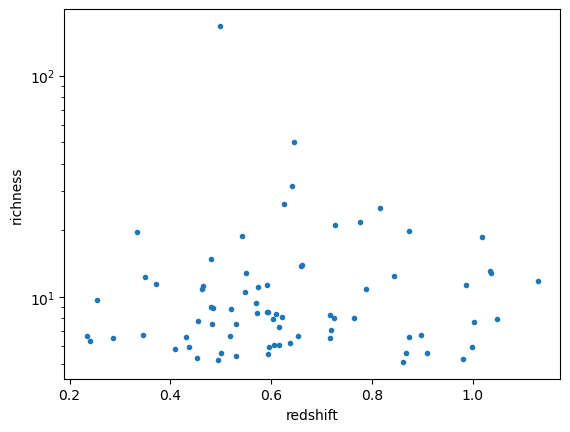

In [16]:
plt.semilogy(dset_in['redshift'][()], dset_in['richness'][()],'.', alpha=1)

plt.xlabel('redshift')
plt.ylabel('richness')

## Open binning output

In [17]:
# open for reading
#output_dir =  '/pbs/home/m/mricci/throng_mricci/desc/TXPipe/data/cosmodc2/outputs-1deg2-CL'
output_dir = '.'

filename_out = output_dir + "/cluster_catalog_tomography.hdf5"
#f2 = txpipe.data_types.TomographyCatalog(filename2, "r")

f_out = h5py.File(filename_out, "r")

In [18]:
print(f_out.keys())

<KeysViewHDF5 ['cluster_bin', 'provenance']>


In [19]:
dat_out = f_out['provenance']
dset_out = f_out['cluster_bin']

In [20]:
print(dset_out.keys())

<KeysViewHDF5 ['bin_zbin_0_richbin_0', 'bin_zbin_0_richbin_1', 'bin_zbin_0_richbin_2', 'bin_zbin_1_richbin_0', 'bin_zbin_1_richbin_1', 'bin_zbin_1_richbin_2', 'bin_zbin_2_richbin_0', 'bin_zbin_2_richbin_1', 'bin_zbin_2_richbin_2']>


In [21]:
[print (i, dict(dset_out[i].attrs), dset_out[i]['redshift'][:].size) for i in dset_out.keys()];

bin_zbin_0_richbin_0 {'rich_max': 10.0, 'rich_min': 5.0, 'z_max': 0.4, 'z_min': 0.1} 5
bin_zbin_0_richbin_1 {'rich_max': 20.0, 'rich_min': 10.0, 'z_max': 0.4, 'z_min': 0.1} 3
bin_zbin_0_richbin_2 {'rich_max': 25.0, 'rich_min': 20.0, 'z_max': 0.4, 'z_min': 0.1} 0
bin_zbin_1_richbin_0 {'rich_max': 10.0, 'rich_min': 5.0, 'z_max': 0.6, 'z_min': 0.4} 20
bin_zbin_1_richbin_1 {'rich_max': 20.0, 'rich_min': 10.0, 'z_max': 0.6, 'z_min': 0.4} 8
bin_zbin_1_richbin_2 {'rich_max': 25.0, 'rich_min': 20.0, 'z_max': 0.6, 'z_min': 0.4} 0
bin_zbin_2_richbin_0 {'rich_max': 10.0, 'rich_min': 5.0, 'z_max': 0.8, 'z_min': 0.6} 13
bin_zbin_2_richbin_1 {'rich_max': 20.0, 'rich_min': 10.0, 'z_max': 0.8, 'z_min': 0.6} 3
bin_zbin_2_richbin_2 {'rich_max': 25.0, 'rich_min': 20.0, 'z_max': 0.8, 'z_min': 0.6} 2


In [22]:
print ([col for col in dset_out['bin_zbin_0_richbin_0']])

['cluster_id', 'dec', 'ra', 'redshift', 'redshift_err', 'richness', 'richness_err', 'scaleval']


## Compare the two 

In [33]:
print('The file contains',len(dset_out.keys()), 'keys corresponding to',
      len(pip_stage.config.zedge) - 1, ' redshift bins times', 
      len(pip_stage.config.richedge) - 1,'richness bins')

The file contains 9 keys corresponding to 3  redshift bins times 3 richness bins


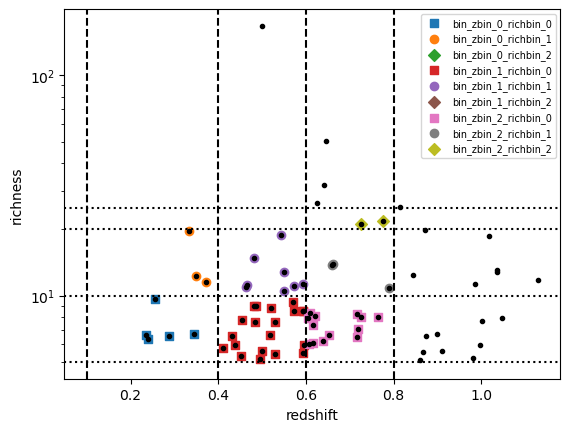

In [36]:
#plot data from input catalog
plt.semilogy(dset_in['redshift'][()], dset_in['richness'][()],'k.', alpha=1)
plt.xlabel('redshift')
plt.ylabel('richness')

#plot bin limits as defined in the config file
[plt.axvline(i,linestyle='dashed', color='black') for i in pip_stage.config.zedge]
[plt.axhline(i,linestyle='dotted', color='black') for i in pip_stage.config.richedge]

#overplot data from output file to make sure the bins are ordered correctly
markers=['s','o', 'D', 'P', '^']

for i in range(len(pip_stage.config.zedge)-1):
    for j in range(len(pip_stage.config.richedge)-1):
        plt.scatter(dset_out['bin_zbin_'+str(i)+'_richbin_'+str(j)]['redshift'][:], 
         dset_out['bin_zbin_'+str(i)+'_richbin_'+str(j)]['richness'][:], marker=markers[j], label='bin_zbin_'+str(i)+'_richbin_'+str(j))
    
    plt.legend(fontsize='x-small')